# Introduction to Synthetic Aperture Radar Using Python and MATLAB

## by Andy Harrison - &copy; Artech House 2022

---

## Example 4.5.1 Polar Format Algorithm - Point Targets
---

**Import Modules**

In [1]:
%matplotlib inline

import numpy as np

from scipy.constants import speed_of_light, pi

from scipy.interpolate import griddata

from matplotlib import pyplot as plt

**Set the range to the image center (m)**

In [2]:
range_center = 1000

**Set the target locations (m) and RCS (m^2)**

In [3]:
x_target = [-10, 5, -8, 8]

y_target = [10, -3, -8, 12]

z_target = [5, 0, -5, 11]

rcs = [10, 10, 7, 5]

**Set the image span (m)**

In [4]:
x_span = 30

y_span = 30

z_span = 30

**Set the number of bins in the image**

In [5]:
nx = 400 # Number of bins in x-direction

ny = 400 # Number of bins in y-direction

nz = 400 # Number of bins in z-direction

**Set the start frequency and bandwidth (Hz)**

In [6]:
start_frequency = 5e9

bandwidth = 100e6

**Set the azimuth span for the synthetic aperture (deg)**

In [7]:
az_start = 5

az_end = 5.5

**Set the elevation span for the synthetic aperture (deg)**

In [8]:
el_start = -0.5

el_end = 0.5

**Set the dynamic range for the image display (dB)**

In [9]:
dynamic_range = 30

**Set up the azimuth space**

In [10]:
r = np.sqrt(x_span**2 + y_span**2)

da = speed_of_light / (2.0 * r * start_frequency)

na = np.round(np.radians(az_end - az_start) / da)

az = np.linspace(az_start, az_end, int(na))

az = az - np.mean(az)

**Set up the elevation space**

In [11]:
r = np.sqrt(x_span**2 + z_span**2)

de = speed_of_light / (2.0 * r * start_frequency)

ne = np.round(np.radians(el_end - el_start) / de) 

el = np.linspace(el_start, el_end, int(ne))

el = el - np.mean(el)

**Set up the frequency space**

In [12]:
df = speed_of_light / (2.0 * r)

nf = np.floor(bandwidth / df)

frequency = np.linspace(start_frequency, start_frequency + bandwidth, int(nf))

**Shorthand and helps with computational load**

In [13]:
ca = np.cos(np.radians(az))

sa = np.sin(np.radians(az))

ce = np.cos(np.radians(el))

se = np.sin(np.radians(el))

**Calculate the signal in wavenumber space**

In [14]:
# Initialize

signal = np.zeros((int(nf), int(na), int(ne)), dtype=complex)

kx = np.zeros((int(nf), int(na), int(ne)))

ky = np.zeros((int(nf), int(na), int(ne)))

kz = np.zeros((int(nf), int(na), int(ne)))

kc = 2 * pi * frequency / speed_of_light



# Loop over all the aspect and elevation angles

ia = 0

for caz, saz in zip(ca, sa):
    
    ie = 0
    
    for cel, sel in zip(ce, se):
        
        r_los = [caz * cel, saz * cel, sel]
        
        kx[:, ia, ie] = kc * saz * cel
        
        ky[:, ia, ie] = kc * caz * cel
        
        kz[:, ia, ie] = kc * sel
        
        for rt, xt, yt, zt in zip(rcs, x_target, y_target, z_target):
            
            r_target = np.dot(r_los, [xt, yt, zt])
            
            signal[:, ia, ie] += rt * np.exp(1j * 2.0 * kc * r_target)
            
        ie += 1
        
    ia += 1

**Set up the 3D wavenumber space for reformatting**

In [15]:
# Find the min and max

kxmin = np.min(kx)

kxmax = np.max(kx)


kymin = np.min(ky)

kymax = np.max(ky)


kzmin = np.min(kz)

kzmax = np.max(kz)



# Set up the wavenumber space

kxp = np.linspace(kxmin, kxmax)

kyp = np.linspace(kymin, kymax)

kzp = np.linspace(kzmin, kzmax)

[kxp, kyp, kzp] = np.meshgrid(kxp, kyp, kzp)

**Perform the interpolation**

In [16]:
new_signal = griddata((kx.ravel(), ky.ravel(), kz.ravel()), signal.ravel(), (kxp, kyp, kzp), method='linear', fill_value=0)

**Get the frequency step size**

In [17]:
frequency_step = speed_of_light / (2 * pi) * (kxp[0,1,0] - kxp[0,0,0])

**Calculate the maximum scene size and resolution**

In [18]:
range_extent = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses**

In [19]:
range_window = np.linspace(-0.5 * range_extent, 0.5 * range_extent, int(nx))

del_r = range_window[1] - range_window[0]

range_window = range_window - del_r/2

**Get the frequency step size**

In [20]:
frequency_step = speed_of_light / (2 * pi) * (kyp[1,0,0] - kyp[0,0,0])

**Calculate the maximum scene size and resolution**

In [21]:
cross_range_extent_az = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses**

In [22]:
cross_range_window_az = np.linspace(-0.5 * cross_range_extent_az, 0.5 * cross_range_extent_az, int(ny))

del_az = cross_range_window_az[1] - cross_range_window_az[0]

cross_range_window_az = cross_range_window_az - del_az/2

**Get the frequency step size**

In [23]:
frequency_step = speed_of_light / (2 * pi) * (kzp[0,0,1] - kzp[0,0,0])

**Calculate the maximum scene size and resolution**

In [24]:
cross_range_extent_el = speed_of_light / (2 * frequency_step)

**Calculate the range window for the pulses**

In [25]:
cross_range_window_el = np.linspace(-0.5 * cross_range_extent_el, 0.5 * cross_range_extent_el, int(nz))

del_el = cross_range_window_el[1] - cross_range_window_el[0]

cross_range_window_el = cross_range_window_el - del_az/2

**Calculate the signal in range, azimuth, and elevation**

In [ ]:
rae_signal = np.fft.fftshift(np.fft.ifftn(new_signal, (nx, ny, nz)))

**Set the scatter data to be plotted**

In [27]:
# Set the dynamic range of the points to be displayed

dynamic_range = 15


# Normalize the signal

a = abs(rae_signal) / np.max(abs(rae_signal))



# Create the image grid

x_image, y_image, z_image = np.meshgrid(range_window, cross_range_window_az, cross_range_window_el, indexing='ij')



# Get the indices for the data

plot_index = a > 10.0**(-abs(dynamic_range) / 20)

xs = x_image[plot_index].tolist()

ys = y_image[plot_index].tolist()

zs = z_image[plot_index].tolist()

rs = (a[plot_index] * 10).tolist()

**Display the results**

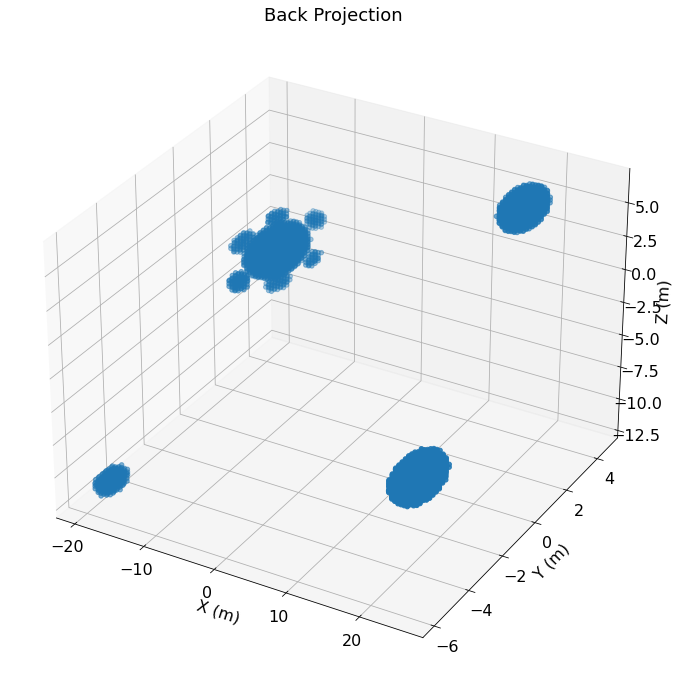

In [28]:
# Set the figure size

plt.rcParams["figure.figsize"] = (15, 12)



# Scatter plot

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs, s=rs, cmap='Greys')



# Set the plot title and labels

ax.set_title('Polar Format', size=18)

ax.set_xlabel('X (m)', size=16)

ax.set_ylabel('Y (m)', size=16)

ax.set_zlabel('Z (m)', size=16)



# Set the tick label size

ax.tick_params(labelsize=16)



# Show the figure

plt.show()